In [1]:
import pandas as pd
import numpy as np
import random
import copy
import torch

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

In [3]:
data = pd.read_csv('../../GeneralData/ETTm2.csv')
data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
69676,2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
69677,2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501
69678,2018-06-26 19:30:00,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501


In [4]:
import torch.nn as nn

In [5]:
feature_size = 7

In [6]:
# LSTM은 Encoder와 Decoder를 각각 구현해야 한다.
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = 14
        self.input_size = feature_size
        self.encoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        # batch_first = True로 인해서 (batch,seq,feature)순으로 입력 받는다.
        # 그 당시에 알고 있는 정보가 없으므로 input_size = 0
        self.decoder = nn.LSTM(input_size = self.input_size,
                       hidden_size = self.hidden_size,
                       num_layers = 1,
                       batch_first = True).to(device)
        
        
        self.output_layer = nn.Linear(self.hidden_size, 1).to(device)
    def forward(self,x):
        x = x.to(device)
        self.encoder.flatten_parameters()
        self.decoder.flatten_parameters()
        outputs,(hidden,cell) = self.encoder(x)
        
        # 현재 prediction_length = 1이기 때문에, 반복문을 돌리지 않아도 됨
        # but 길어진다면 반복문을 돌려서 output값을 얻어야 한다.
        # 기본적으로 output = hidden state이기에 output을 생성할
        # Fully Connected Layer가 필요하게 된다.
        # 이때 decoder_output의 사이즈는 (batch,seq,hidden) 이다
        # 중간에 seq가 들어오게 되는 이유는 입력 크기 만큼 lstm이 반복되기 때문에
        # seq=1 이기 때문에 squeeze를 수행
        
        hidden = hidden.to(device)
        cell = cell.to(device)
        decoder_input = torch.zeros([x.size(0),1,x.size(2)]).to(device)
        decoder_out,(hidden,cell) = self.decoder(decoder_input,(hidden,cell))
        decoder_out = decoder_out.squeeze(1)
        
        out = self.output_layer(decoder_out)
        
        return out

In [7]:
a = np.array([1,2,3])
a.shape[0]

3

In [8]:
lst = [i for i in range(1,13)]
A = torch.FloatTensor(lst).view(3,2,2)
B = torch.zeros((2,2))
B[0,0] = 1
B[1,1] = 1
A*B # BroadCasting

tensor([[[ 1.,  0.],
         [ 0.,  4.]],

        [[ 5.,  0.],
         [ 0.,  8.]],

        [[ 9.,  0.],
         [ 0., 12.]]])

In [9]:
class Filter(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = LSTM()
    def forward(self,x,train_index_matrix=[]):
        # 2차원 인덱스 리스트가 들어온다.
        # train_index_matrix = 2차원
        # 행은 time 열은 Feature를 의미
        if len(train_index_matrix)==0:
            return self.model(x)
        filters = torch.FloatTensor(np.zeros((x.shape[1],x.shape[2])))
        filters = filters.to(device)
        for i in range(len(train_index_matrix)):
            for train_idx in train_index_matrix[i]:
                filters[train_idx,i] = 1
        x = x*filters
        out = self.model(x)
        return out

In [10]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch

In [11]:
device = torch.device("cuda:0")

In [12]:
sequence_length = 1440 # 24*60 60일
pred_length = 1 # 1시간
split = int(len(data)*0.8)

In [13]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length):
        # 시간데이터를 제외하고 추출
        seq_list.append(x.iloc[i:i+sequence_length,1:].values)
        # OT만 추출
        target_list.append(x.iloc[i+sequence_length,-1])
        
    return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)

In [ ]:
train = data.iloc[:split]
val = data.iloc[split:]

X_train, y_train = seq_data(train,sequence_length,pred_length)
X_val, y_val = seq_data(val,sequence_length,pred_length)

tr_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val,y_val)

training =  DataLoader(tr_dataset,batch_size = 64)
validation = DataLoader(val_dataset,batch_size = 64)

/tmp/ipykernel_1310630/2507691695.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(seq_list).view(-1,sequence_length,7).to(device), torch.FloatTensor(target_list).view(-1,pred_len,1).to(device)


In [ ]:
torch.cuda.is_available()

In [ ]:
X_train.size() # 168개의 sequence_length 7개의 Feature

* 잘 데이터가 구성된 걸 확인 가능

In [ ]:
train.iloc[:169]

In [ ]:
X_train

In [ ]:
y_train

In [ ]:
from torch.optim import Adam

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
model = Filter().to(device)
optimizer = Adam(model.parameters(),lr = 1e-4)
num_epochs = 200
n = len(training)

In [ ]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [ ]:
model.named_parameters

In [ ]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

In [ ]:
from captum.attr import IntegratedGradients,NoiseTunnel

In [ ]:
for val in validation:
    print(val[0].size())

In [ ]:
test = next(iter(validation))[0][0] # 하나의 sample에 대해서 진행
test = test.unsqueeze(0)
test.size()

In [ ]:
ig = IntegratedGradients(model)
attr_score = ig.attribute(test,return_convergence_delta=True)
attr_score

In [ ]:
attr_score[0].size()

In [ ]:
delta = attr_score[1]

In [ ]:
attr_score = attr_score[0]

In [ ]:
attr_score.to("cpu")

In [ ]:
plot_attribution = attr_score.to("cpu").detach().numpy()
plot_attribution

In [ ]:
plot_attribution = plot_attribution.reshape(-1,7)

In [ ]:
column = data.columns[1:]
column

In [ ]:
attr_df = pd.DataFrame(plot_attribution,columns=column)

In [ ]:
attr_df

# 특징 관찰

### our goal -> 특정 시간대를 추출해내는 방법을 고안

In [ ]:
next(iter(validation))[1][0]

* 전체 Attribution DataFrame이 예측값을 나눈것으로 보임
    * 현재 하나의 Sample Batch의 첫번째 Sample에 대해서 Attribution을 구했는데
    하나의 DataFrame이 나왔음

In [ ]:
attr_df.sum(axis=0).sum()

1. delta가 attribution 유의미하게 작은지 확인
2. baseline vector 넣었을떄 0인지

### 1의 답

In [ ]:
delta

In [ ]:
test_baseline = torch.FloatTensor(np.zeros((1,sequence_length,7)))
base_pred = model(test_baseline)
base_pred

### 2의 답

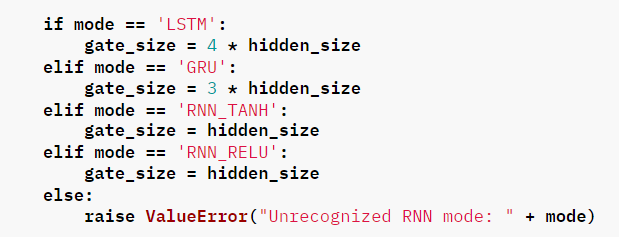
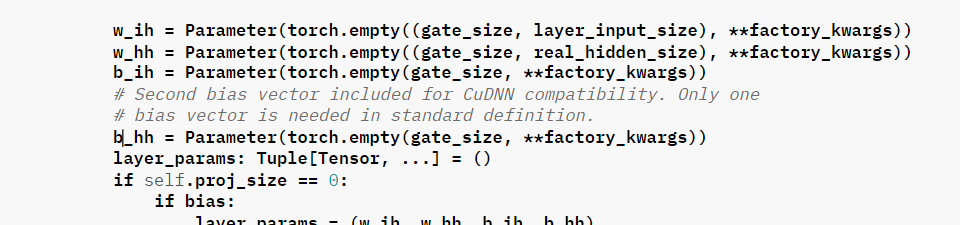

<font color = blue><font size = 5> what is CuDNN Compatibility?</font></font>

https://pytorch.org/docs/stable/_modules/torch/nn/modules/rnn.html

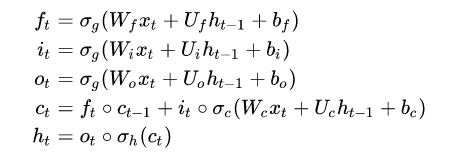

* **LSTM의 bias는 4개가 존재하고 따라서 4*hiddensize만큼의 bias element갯수가 존재한다.**

In [ ]:
bias1 = model.model.encoder.bias_hh_l0
bias1

In [ ]:
bias1.sum(axis=0)

In [ ]:
model.model.encoder.bias_hh_l0.size()

In [ ]:
bias2 = model.model.encoder.bias_ih_l0
bias2

In [ ]:
bias2.sum(axis = 0)

* 하나의 샘플은 모두 (168,7)의 동일한 크기를 갖는다.

In [ ]:
cnt = 0
ig = IntegratedGradients(model)
ig_attr_score = np.zeros((sequence_length,feature_size))
for val_batch in validation:
    temp_n = val_batch[0].size(0)
    for val in val_batch[0]: # 하나의 배치에 대해서 for문
        val = val.unsqueeze(0)
        temp = ig.attribute(val).abs()
        # 각 attribution score의 절대값을 합한다.
        # 이로써 각 시간별로 영향도를 구함
        # 이 부분이 abs를 씌우는게 절대적인 영향을 반영하는데에 맞는 것 같다.
        # 이전까진 씌우지 않았음
        temp = temp.squeeze(0)
        temp = temp.to("cpu").detach().numpy()   
        ig_attr_score = ig_attr_score+temp
    cnt = cnt + temp_n
ig_attr_score = ig_attr_score/cnt

In [ ]:
data.columns[1:]

In [ ]:
ig_attr_score[:,0]

In [ ]:
np

In [ ]:
sub_attr_df = []
for cnt,column in enumerate(list(data.columns[1:])):
    attr_df = pd.DataFrame(ig_attr_score[:,0],columns = [column])
    sub_attr_df.append(attr_df)
sub_attr_df

In [ ]:
candidate_sub_attr_df = []
for attr_df in sub_attr_df:
    IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
    outlier_max = attr_df.quantile(0.75)+IQR
    outlier_min = attr_df.quantile(0.25)-IQR
    candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
    candidate_attr = candidate_attr.dropna()
    candidate_sub_attr_df.append(candidate_attr)
candidate_sub_attr_df

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
filtering_attr_list = [] # scaling한 attribution dataframe을 저장
fig,ax = plt.subplots(7,1,figsize = (10,20))
for cnt,candidate_attr in enumerate(candidate_sub_attr_df):
    scaler = MinMaxScaler()
    scaler.fit(candidate_attr.values)
    m_attr_df = scaler.transform(candidate_attr.values)
    m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
    filtering_attr_list.append(m_attr_df)
    ax[cnt].plot(m_attr_df)
    ax[cnt].set_title(candidate_attr.columns.item())
filtering_attr_list

In [ ]:
total_index_list = [] # train할 index를 저장해두는 리스트이다.
for hyper_para in np.arange(0.00,1.00,0.01):
    index_list = []
    # filtering index를 만든다.
    for m_attr_df in filtering_attr_list:
        append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
        index_list.append(append_idx)
    total_index_list.append(index_list)
len(total_index_list) 

In [ ]:
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE

In [ ]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for sub_index_list in total_index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = sub_index_list
    minimal_loss=np.inf
    model = Filter().to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs,train_idx)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

In [ ]:
len(mse_out_list)

In [ ]:
plt.plot(mse_out_list)

In [ ]:
plt.plot(mae_out_list)

In [ ]:
plt.plot(rmse_out_list)

In [ ]:
plt.plot(smape_out_list)